# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="Tennis.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [89]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = [[0,0],[0,0]] #np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

Score (max over agents) from episode 1: 0.09000000357627869
Score (max over agents) from episode 2: 0.0
Score (max over agents) from episode 3: 0.0
Score (max over agents) from episode 4: 0.09000000357627869
Score (max over agents) from episode 5: 0.0


When finished, you can close the environment.

In [6]:
#env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import time, os

import numpy as np
import random
import copy
from collections import namedtuple, deque

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

LR_ACTOR = 1e-4         # learning rate of the actor
LR_CRITIC = 3e-4        # learning rate of the critic
WEIGHT_DECAY = 0        # L2 weight decay 0

NOISE_REDUCTION_RATE = 0.99
EPISODES_BEFORE_LEARNING = 400
NOISE_START=1.0
NOISE_END=0.1

BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 200        # minibatch size

GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters (1)

# Neural Network hidden layers for actor and critic
NN_ACTOR_HIDDEN_1 = 128
NN_ACTOR_HIDDEN_2 = 100
NN_CRITIC_HIDDEN_1 = 128
NN_CRITIC_HIDDEN_2 = 96

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#global variable to share the critic on both agents
shared_critic_local = None
shared_critic_target = None
shared_critic_optim = None

In [6]:
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed=0, fc1_units=256, fc2_units=128):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.bn1 = nn.BatchNorm1d(fc1_units)
        self.bn2 = nn.BatchNorm1d(fc2_units)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        if state.dim() == 1:
            state = torch.unsqueeze(state,0)
        x = F.relu(self.fc1(state))
        x = self.bn1(x)
        x = F.relu(self.fc2(x))
        return torch.tanh(self.fc3(x))

class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, full_state_size, actions_size, seed=0, fcs1_units=256, fc2_units=128):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(full_state_size, fcs1_units)
        self.fc2 = nn.Linear(fcs1_units+actions_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.bn1 = nn.BatchNorm1d(fcs1_units)
        self.bn2 = nn.BatchNorm1d(fc2_units)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        xs = F.relu(self.fcs1(state))
        xs = self.bn1(xs)
        x = torch.cat((xs, action), dim=1)
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [7]:
class Agent():
    """Interacts with and learns from the environment."""
    
    def __init__(self, state_size=24, action_size=2, num_agents=2, random_seed=1, fc1_units=128, fc2_units=64,critic_h1=128,critic_h2=64):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)

        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size, random_seed,fc1_units=fc1_units, fc2_units=fc2_units).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed,fc1_units=fc1_units, fc2_units=fc2_units).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)

        global shared_critic_local, shared_critic_target, shared_critic_optim
        
        # Critic Network (w/ Target Network) shared by all agents
        if shared_critic_local is None:
            #print('shared_critic_local is initialized')
            self.critic_local = Critic(state_size*num_agents, action_size*num_agents, random_seed,fcs1_units=critic_h1, fc2_units=critic_h2).to(device)
            self.critic_target = Critic(state_size*num_agents, action_size*num_agents, random_seed,fcs1_units=critic_h1, fc2_units=critic_h2).to(device)
            self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)
            shared_critic_local = self.critic_local
            shared_critic_target = self.critic_target
            shared_critic_optim = self.critic_optimizer
        else:
            #print('reuse critic on this actor')
            self.critic_local = shared_critic_local
            self.critic_target = shared_critic_target
            self.critic_optimizer = shared_critic_optim

        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)
        
        # Noise process
        self.noise = OUNoise(action_size, random_seed)
        self.noise_reduction_ratio = NOISE_START

        self.step_count = 0

    def act(self, state, i_episode, add_noise=True):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        
        if add_noise:
            if i_episode > EPISODES_BEFORE_LEARNING and self.noise_reduction_ratio > NOISE_END:
                self.noise_reduction_ratio = NOISE_REDUCTION_RATE**(i_episode - EPISODES_BEFORE_LEARNING)
            action += self.noise_reduction_ratio * self.add_noise2()
        return np.clip(action, -1, 1)

    def add_noise2(self):
        noise = 0.5*np.random.standard_normal(self.action_size)
        return noise
    
    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        full_states, actions, actor_local_actions, actor_target_actions, agent_state, agent_action, agent_reward, agent_done, next_states, next_full_states = experiences

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        Q_targets_next = self.critic_target(next_full_states, actor_target_actions)
        # Compute Q targets for current states (y_i)
        Q_targets = agent_reward + (gamma * Q_targets_next * (1 - agent_done))
        # Compute critic loss
        Q_expected = self.critic_local(full_states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actor_loss = -self.critic_local(full_states, actor_local_actions).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

    def hard_copy_weights(self, target, source):
        """ copy weights from source to target network (part of initialization)"""
        for target_param, param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(param.data)
            
    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.1):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()
        self.size = size

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.standard_normal(self.size)
        self.state = x + dx
        return self.state

In [11]:
class MADDPG():
    
    def __init__(self, state_size=24, action_size=2, num_agents=2, random_seed=1, fc1_units=128, fc2_units=64,critic_h1=128,critic_h2=64):
        
        self.state_size = state_size
        self.action_size = action_size
        self.random_seed = random.seed(random_seed)
        
        # creating agents and store them into agents list
        self.agents = [Agent(state_size, action_size, num_agents, random_seed, fc1_units=fc1_units, fc2_units=fc2_units,critic_h1=critic_h1,critic_h2=critic_h2) for i in range(num_agents)]
        
        # Replay memory
        self.memory = ReplayBuffer(BUFFER_SIZE, BATCH_SIZE, random_seed)
        self.step_count = 0
        
    # reset each agent's noise
    def reset(self):
        for agent in self.agents:
            agent.reset()
            
    # state: state array for all agents [agent_no, state_size]
    # output: actions of all agents [agent_no, action of an agent]
    def act(self, state, i_episode, add_noise=True):
        actions = []
        for agent_state, agent in zip(state, self.agents):
            action = agent.act(agent_state, i_episode, add_noise)
            action = np.reshape(action, newshape=(-1))
            actions.append(action)
        actions = np.stack(actions)
        return actions
        
    
    def step(self, i_episode, state, action, reward, next_state, done):
        full_state = np.reshape(state, newshape=(-1))
        next_full_state = np.reshape(next_state, newshape=(-1))
        
        self.memory.add(state, full_state, action, reward, next_state, next_full_state, done)
        
        self.step_count = self.step_count + 1
        
        if len(self.memory) > BATCH_SIZE and i_episode > EPISODES_BEFORE_LEARNING:

            for a_cnt in range(3):
                i_agent = 0
                for agent in self.agents:
                    i_agent +=1
                    if ((self.step_count +i_agent) % 2) != 0:
                        experiences = self.memory.sample()
                        self.learn(experiences, agent, GAMMA)

                for agent in self.agents:
                    i_agent +=1
                    if ((self.step_count +i_agent) % 2) != 0:
                        agent.soft_update(agent.actor_local, agent.actor_target, TAU)
                    agent.soft_update(agent.critic_local, agent.critic_target, TAU)

    # execute learning on an agent    
    def learn(self, experiences, agent, GAMMA):
        # batch dataset for training
        states, full_states, actions, rewards, next_states, next_full_states, dones = experiences
                
        # compute NO-NOISE action using target actor and current state - [batch_size, # of agent, action size]
        # this will be used as input on critic local network
        actor_target_actions = torch.zeros(actions.shape, dtype=torch.float, device=device)
        for agent_idx, agent_i in enumerate(self.agents):
            if agent == agent_i:
                agent_id = agent_idx
            agent_i_current_state = states[:,agent_idx]
            actor_target_actions[:,agent_idx,:] = agent_i.actor_target.forward(agent_i_current_state)
        actor_target_actions = actor_target_actions.view(BATCH_SIZE, -1)
        
        # agent specific state, action, reward, done
        agent_state = states[:,agent_id,:]
        agent_action = actions[:,agent_id,:]
        agent_reward = rewards[:,agent_id].view(-1,1)
        agent_done = dones[:,agent_id].view(-1,1)
        
        # replace action of the specific agent with actor_local output (NOISE removal)
        actor_local_actions = actions.clone()
        actor_local_actions[:, agent_id, :] = agent.actor_local.forward(agent_state)
        actor_local_actions = actor_local_actions.view(BATCH_SIZE, -1)
                
        # flatt actions
        actions = actions.view(BATCH_SIZE, -1)
        
        agent_experience = (full_states, actions, actor_local_actions, actor_target_actions,
                            agent_state, agent_action, agent_reward, agent_done,
                            next_states, next_full_states)

        agent.learn(agent_experience, GAMMA)

    def save(self, prefix=''):
        for idx, agent in enumerate(self.agents):
            chk_actor_filename = prefix + 'checkpoint_agent{}_actor.pth'.format(idx)
            chk_critic_filename = prefix + 'checkpoint_critic{}_critic.pth'.format(idx)
            torch.save(agent.actor_local.state_dict(), chk_actor_filename)
            torch.save(agent.critic_local.state_dict(), chk_critic_filename)

class ReplayBuffer(object):
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=['state', 'full_state', 'action', 'reward', 'next_state', 'next_full_state','done'])
        self.seed = random.seed(seed)
    
    def add(self, state, full_state, action, reward, next_state, next_full_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, full_state, action, reward, next_state, next_full_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)
        
        states = torch.from_numpy(np.array([e.state for e in experiences if e is not None])).float().to(device)
        full_states = torch.from_numpy(np.array([e.full_state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.array([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.array([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.array([e.next_state for e in experiences if e is not None])).float().to(device)
        next_full_states = torch.from_numpy(np.array([e.next_full_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.array([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, full_states, actions, rewards, next_states, next_full_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory) 

In [12]:
maddpg = MADDPG(state_size=24, action_size=2, num_agents=2, fc1_units=NN_ACTOR_HIDDEN_1, fc2_units=NN_ACTOR_HIDDEN_2, critic_h1=NN_CRITIC_HIDDEN_1,critic_h2=NN_CRITIC_HIDDEN_2) 


0 episode	avg score over 100 episodes 0.10000	 (max 0.10000)
100 episode	avg score over 100 episodes 0.01640	 (max 0.00000)
200 episode	avg score over 100 episodes 0.01370	 (max 0.00000)
300 episode	avg score over 100 episodes 0.01820	 (max 0.00000)
400 episode	avg score over 100 episodes 0.01850	 (max 0.00000)
500 episode	avg score over 100 episodes 0.00000	 (max 0.00000)
600 episode	avg score over 100 episodes 0.01940	 (max 0.10000)
700 episode	avg score over 100 episodes 0.07040	 (max 0.09000)
800 episode	avg score over 100 episodes 0.08650	 (max 0.10000)
900 episode	avg score over 100 episodes 0.10820	 (max 0.10000)
1000 episode	avg score over 100 episodes 0.16830	 (max 0.20000)
1100 episode	avg score over 100 episodes 0.31460	 (max 0.29000)
1151 episode	avg score over 100 episodes 0.50940	 (max 1.80000)
Environment solved after 1151 episodes with the average score 0.5094000076502562



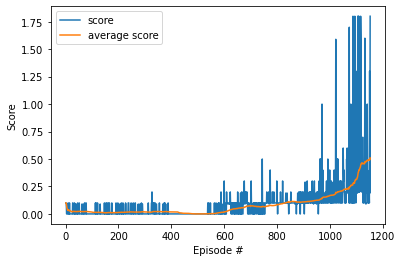

In [13]:
scores_max_hist = []
scores_mean_hist = []

def maddpg_train(n_episodes=5000, print_eval=100):
    
    scores_deque = deque(maxlen=print_eval)
    solved = False
    
    for i_episode in range(n_episodes):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations
        scores = np.zeros(num_agents)
        maddpg.reset()
        step = 0
        while True:
            step += 1
            action = maddpg.act(state, i_episode, add_noise=True)
            env_info = env.step(action)[brain_name]
            
            next_state = env_info.vector_observations
            reward = env_info.rewards
            done = env_info.local_done
            
            scores += reward
            
            maddpg.step(i_episode, state, action, reward, next_state, done)
            
            if np.any(done) or np.max(scores) > 1.79: # it is possible agent to be cheating, so we stop!
                break
                
            state = next_state
            
        score_max = np.max(scores)
        scores_deque.append(score_max)
        score_mean = np.mean(scores_deque)
        
        scores_max_hist.append(score_max)
        scores_mean_hist.append(score_mean)

        print('\r{} episode\tavg score over {} episodes {:.5f}\t (max {:.5f})'.format(i_episode, print_eval, np.mean(scores_deque), score_max), end='')
        if solved == False and score_mean >= 0.5:
            print('\nEnvironment solved after {} episodes with the average score {}\n'.format(i_episode, score_mean))
            maddpg.save()
            solved = True
        
        if i_episode % print_eval == 0:
            print()

        if i_episode % 250 == 0:
            maddpg.save('partial_')

        if np.mean(scores_deque) > 0.5:
            break
    
    return solved


solved = maddpg_train(n_episodes=2000)

if not solved:
    maddpg.save('not_solved_')

# Visualization
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores_max_hist)+1), scores_max_hist, label='score')
plt.plot(np.arange(1, len(scores_mean_hist)+1), scores_mean_hist, label='average score')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(loc='upper left')
plt.show()

In [ ]:
#env.close()  # close the environment

In [14]:
agent = Agent(state_size=24, action_size=2, num_agents=2, fc1_units=NN_ACTOR_HIDDEN_1, fc2_units=NN_ACTOR_HIDDEN_2, critic_h1=NN_CRITIC_HIDDEN_1,critic_h2=NN_CRITIC_HIDDEN_2)

agent.actor_local.load_state_dict(torch.load('checkpoint_agent0_actor.pth', map_location='cpu'))
agent.critic_local.load_state_dict(torch.load('checkpoint_critic0_critic.pth', map_location='cpu'))

for i in range(10):
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state
    scores = np.zeros(num_agents)                          # initialize the score
    while True:
        actions = agent.act(states,i, add_noise= False)
        env_info = env.step(actions)[brain_name]
        next_states = env_info.vector_observations
        rewards = env_info.rewards
        dones = env_info.local_done
        scores += env_info.rewards
        states = next_states
        if np.any(dones):
            break
    
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 2.600000038743019
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: 2.600000038743019
Total score (averaged over agents) this episode: 2.600000038743019
Total score (averaged over agents) this episode: 2.600000038743019
Total score (averaged over agents) this episode: 2.650000039488077
Total score (averaged over agents) this episode: 2.600000038743019
Total score (averaged over agents) this episode: 0.19500000309199095
Total score (averaged over agents) this episode: 2.600000038743019
Total score (averaged over agents) this episode: 2.600000038743019


In [15]:
env.close()